# Model selection assessment

The objective of this notebook is to compare the different classical model selection approaches, and to learn one more adapted to clonesig.

A few notations
- $N$ is the number of observations
- $J$ is the number of clones, $D_J$ is the number of parameters for a model with $J$ clones
- $\ell$ is the log likelihood of the model, namely $\ell(\mathcal{D};\boldsymbol{\theta}) = \sum_{n=1}^N \log \left[ \sum_{u=1}^U \sum_{s=1}^L \sum_{m=1}^{M_{max_n}} \xi_u \mu_{st} \pi_{us} \nu_{mn} BB(B_n|D_n, C_n, p, U_n=u, M_n=m;\boldsymbol{\theta})\right]$


We have $D_J = J * (L - 1 + 2)$, with $L$ the number of signatures. Indeed, for each clone, we have $L-1$ parameters for the signature proportions ($\pi$), the frequency of the clone ($\phi_u$), and the proportion of the clone $\xi_u$. We have to remove 1 because $\sum_{u=1}^J \xi_u=1$, and add 1 for the overdispersion parameter $\tau$.

The definitions of the different indices have been adapted so that they are all in the form of $\ell(\mathcal{D};\boldsymbol{\theta}_J) - pen(J)$ for easier comparison, following notations from [Assessing a Mixture Model for Clustering with the
Integrated Classification Likelihood - 
Christophe Biernacki, Gilles Celeux, Gérard Govaert, 2006](https://hal.inria.fr/inria-00073163/document)

**BIC**
$$BIC = \ell(\mathcal{D};\boldsymbol{\theta}_J) - \frac{D_J}{2}\log N$$

**AIC**
$$AIC = \ell(\mathcal{D};\boldsymbol{\theta}_J) - D_J $$

**AICC**
some adapted version of AIC for small N (might be relevant for TCGA)
$$AICc = AIC + \frac{D_J(D_J+1)}{n-D_J -1}$$

**ICL**
$$ICL=BIC + H = BIC - \sum_{n=1}^N \sum_{u=1}^J \sum_{s=1}^L \sum_{m=1}^{M_{max_n}} q_{un}r_{nus} v_{mnu}  \log (q_{un}r_{nus}v_{mnu})$$

In fact I don't understand anything, there are a lot of different definitions.... This is the definition in [EM for mixtures - Initialization requires special care](https://hal.inria.fr/hal-01113242/document) but there are others:

in [Slope heuristics for variable selection and clustering via
Gaussian mixture](https://hal.inria.fr/inria-00284620v2/document) it is $$ICL_{qn}=BIC + H = BIC - \frac{\sum_{n=1}^N \sum_{u=1}^J \sum_{s=1}^L \sum_{m=1}^{M_{max_n}} U_{un} S_{uns} M_{num} \log (q_{un}r_{nus}v_{mnu})}{N}$$ with $U_{un}=1$ if $u=\mbox{argmax}_v q_{vn}$ and $S_{uns}=1$ if $u=\mbox{argmax}_v q_{vn}$ and $s=\mbox{argmax}_t r_{nut}$, and $M_{num}=1$ if $u=\mbox{argmax}_v q_{vn}$ and $m=\mbox{argmax}_{m'} v_{m'nu}$.

in [Assessing a Mixture Model for Clustering with the
Integrated Classification Likelihood](https://hal.inria.fr/inria-00073163/document) it is $$ICL_{q}=BIC + H = BIC - \sum_{n=1}^N \sum_{u=1}^J \sum_{s=1}^L \sum_{m=1}^{M_{max_n}} U_{un} S_{uns} M_{num} \log (q_{un}r_{nus} v_{mnu})$$


Clearly the computation in this last paper is correct, so let's keep it, and the normalized version. I named them ICL_{q} and ICL_{qn} to avoid confusion. Obviously, the MOBSTER paper (new ITH method using ICL) made a mistake about that in the manuscript...

**SH (slope heuristics)**
$$SH=\ell(\mathcal{D};\boldsymbol{\theta}_J) -\rho D_J $$
where $\rho_{opt}= 2\rho_{min}$ and $\rho_{min}$ is estimated as is the slope of $\ell(\mathcal{D};\boldsymbol{\theta}_J)$ with respect to $D_J$

**"elbow" detection**
the idea is to compute the discrete second derivative as a proxy for the cuvature
$$ x[i+1] + x[i-1] - 2 * x[i]$$


In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from clonesig.data_loader import MAFLoader, SimLoader, beta_binomial
from clonesig.estimator import _get_projected
from clonesig.estimator import *
import time
from sklearn.cluster import KMeans
from sklearn import linear_model
from scipy.stats import pearsonr, linregress
from sklearn.model_selection import GroupKFold
from sklearn.svm import LinearSVC, SVC
from scipy.spatial.distance import cosine
pd.options.display.max_columns = 200

phd_folder_path = '/Users/JudithAbecassis/Documents/PhD'
os.chdir('{}/TCGA_signatures'.format(phd_folder_path))

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Penalty learning

We have generated a set of 6300 simulated dataset with the following characteristics
- each example has a cancertype, and a subset of active signatures drawn at random from this cancer type active signatures, as reported in the table in SigProfiler package.
- each example has a number of mutations among 100, 300, 600, 1000 or 5000
- each example has a theoretic proportion of genome that is diploid of 0, 20, 40, 60, 80, 100. For each simulation, the actual average major copy number was computed
- each example has a different number of clones, between 1 and 6
- for each clone, a different exposure among the active signatures was computed. Those exposure vectors were simulated such that the cosine distance of the mixture was greater than 0.05 between 2 successive clones. The min, max and average distance between the profiles of all pairs of clones was computed.

For each cancer type (35 distinct), there were 180 simulations (1 for each combination of number of clones, number of mutations, and percentage of the genome that is diploid). For each simulation, clonesig was applied twice, one with only the subset of signatures active in the cancer type, and one with the all 65 signatures, with between 1 and 10 clones (included).

All simulations are otherwise independant.

### Learn several models: see if we should have CN or no CN, and number of signatures or degree of freedom
In most models, the penalty depends on $D_J$, the number of parameters in the model. This can be revisited in terms of degree of freedom. The parameters $\phi$, $\xi$ and $\rho$ determining the CCFs and proportions of the different clones in the mixture are unquestionable. Regarding the signatures however, one can notice that the signatures are neither orthogonal (some signatures are very similar), nor independant (some signatures are associated with the same underlying biological process). We have approximated the degree of freedom by the number of non-zero eigenvalues of the cosine similarity matrix of signatures (in practice, we considered the number of eigenvalues greater than $0.5$ in absolute value). Another source of degree of freedom is the copy number. Indeed, for each observed mutation, several values of the number of mutated copies are considered, so if the maximal average multiplicity for mutations in the sample is $M_{max_{avg}}$, a unique clone CCF corresponds to $M_{max_{avg}}$ possible VAFs, adding some freedom to the model.

We have hence considered 4 possible shapes for $D_J$, indexed with letters A to D.
\begin{align}
D_J^A &= J \times (L + 1) \times M_{max_{avg}} \times \log(N) \\
D_J^B &= J \times (L + 1) \times \log(N) \\
D_J^C &= J \times (\mbox{dof}_L + 1) \times M_{max_{avg}} \times \log(N) \\
D_J^D &= J \times (\mbox{dof}_L + 1) \times \log(N) \\
\end{align}

Moreover, if we consider the variations of the degree of freedom associated with $L$ signatures, $\mbox{dof}_L$, as a function of $L$ for the 35 available cancer types, and for the all 65 signatures, we note that there is a gap, as the maximal number of signatures in one cancer type is 19, and that the slope seems different for a subset or for all the signatures. The dependency is quite different, so we have attempted to lean a single model or 2 different models for each shape of $D_J$: one for the case where Clonesig is run with only cancer type-specific signatures, and one for the case where Clonesig is run with all the 65 signatures.

To learn the penalty, the data was divided in train and test sets (

In [4]:
sig_file_path = 'external_data/sigProfiler_SBS_signatures_2018_03_28.csv'
cancer_type_sig_filename = 'external_data/match_cancer_type_sig_v3.csv'

# open the matrix describing the signatures
SIG = pd.read_csv(sig_file_path)
SIG_MATRIX = SIG.values[:, 2:].astype(float).T
L, K = SIG_MATRIX.shape
NEW_SIG_MATRIX = SIG_MATRIX + 10**-20 * (SIG_MATRIX == 0)
MU = NEW_SIG_MATRIX / NEW_SIG_MATRIX.sum(axis=1)[:, np.newaxis]

# get the signatures specific of the cancer type
cancer_type_sig = pd.read_csv(cancer_type_sig_filename, index_col=0)
#select = cancer_type_sig[cancer_type, :]
#subMU = MU[select.astype(bool), :]


nb_sig_list = list()
dof_list = list()
median_list = list()
mean_list = list()
for i, cancer_type in enumerate(cancer_type_sig.index.unique()):
    select = cancer_type_sig.loc[cancer_type, :].values
    subMU = MU[select.astype(bool), :]
    ev, _ = np.linalg.eig(1-sp.spatial.distance.squareform(sp.spatial.distance.pdist(subMU, 'cosine')))
    print(cancer_type, len(ev), sum(ev>0.5))
    subL = subMU.shape[0]
    nb_sig_list.append(subL)
    dof_list.append(sum(ev>0.5))
    dist_list = list()
    for j in range(10000):
        #nb_active_sig = np.min((np.random.poisson(int(subL/2)) + 1, subL))
        nb_active_sig = 4
        #nb_active_sig = subL
        active_signatures = np.random.choice(subL, nb_active_sig, replace=False)
        pi = np.zeros((2, subL))
        pi[0, active_signatures] = np.random.dirichlet(alpha=np.ones(nb_active_sig))
        pi[1, active_signatures] = np.random.dirichlet(alpha=np.ones(nb_active_sig))
        dist_list.append(cosine(pi[0, :].dot(subMU), pi[1, :].dot(subMU)))
    median_list.append(np.median(dist_list))
    mean_list.append(np.mean(dist_list))
df_cancer_type = pd.DataFrame(data=np.array([nb_sig_list, dof_list, median_list, mean_list]).T, columns=['nb_sig', 'dof', 'median_dist', 'mean_list'], index=cancer_type_sig.index)


BILIARY-ADENOCA 19 9
BLADDER-TCC 8 5
BONE-BENIGN 6 4
BONE-EPITH 8 5
BONE-OSTEOSARC 10 7
BREAST-ADENOCA 14 9
BREAST-LOBULARCA 6 5
CERVIX-ADENOCA 4 4
CERVIX-SCC 7 6
CNS-GBM 9 5
CNS-MEDULLO 9 5
CNS-OLIGO 6 4
CNS-PILOASTRO 7 4
COLORECT-ADENOCA 9 7
ESO-ADENOCA 12 8
HEAD-SCC 12 8
KIDNEY-CHRCC 8 7
KIDNEY-RCC 10 7
LIVER-HCC 18 10
LUNG-ADENOCA 12 8
LUNG-SCC 7 5
LYMPH-BNHL 16 9
LYMPH-CLL 5 3
MYELOID-AML 4 3
MYELOID-MPN 7 4
OVARY-ADENOCA 13 7
PANC-ADENOCA 15 10
PANC-ENDOCRINE 14 8
PROST-ADENOCA 17 10
SKIN-MELANOMA 9 6
SOFTTISSUE-LEIOMYO 7 5
SOFTTISSUE-LIPOSARC 8 5
STOMACH-ADENOCA 17 10
THY-ADENOCA 7 4
UTERUS-ADENOCA 11 7


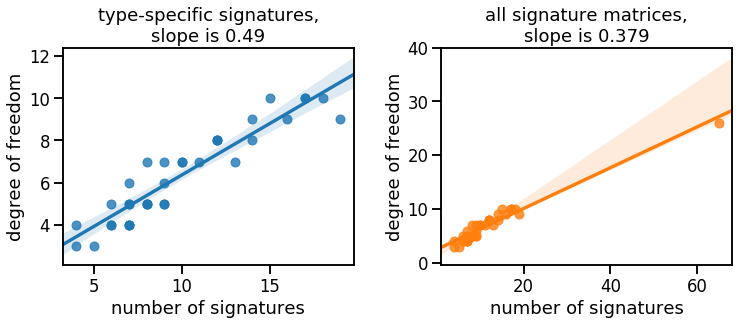

In [23]:
sns.set_context("talk")
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.regplot(x='nb_sig', y='dof', data=df_cancer_type, ax=ax[0])
slope, _, _,_ ,_ = linregress(df_cancer_type['nb_sig'],df_cancer_type['dof'])
ax[0].set_title('type-specific signatures,\nslope is {}'.format(np.round(slope, 3)))
ax[0].set_xlabel("number of signatures")
ax[0].set_ylabel("degree of freedom")
df_cancer_type_full = df_cancer_type.copy()
df_cancer_type_full.loc['all'] = [65, 26, np.nan, np.nan]
sns.regplot(x='nb_sig', y='dof', data=df_cancer_type_full, ax=ax[1])
slope, _, _,_ ,_ = linregress(df_cancer_type_full['nb_sig'],df_cancer_type_full['dof'])
ax[1].set_title('all signature matrices,\nslope is {}'.format(np.round(slope, 3)))
plt.subplots_adjust(wspace=0.3)
ax[1].set_xlabel("number of signatures")
ax[1].set_ylabel("degree of freedom")
plt.savefig('20190801_paper_figures/nb_sig_dof.pdf', bbox_inches='tight')

In [24]:
df_cancer_type = df_cancer_type.assign(nb_sig=df_cancer_type.nb_sig.astype(int))
df_cancer_type = df_cancer_type.assign(cancer_type=list(range(len(df_cancer_type))))
df_cancer_type_bis = df_cancer_type.copy()
df_cancer_type_bis = df_cancer_type_bis.assign(nb_sig=MU.shape[0])
big_df_cancer_type = pd.concat((df_cancer_type, df_cancer_type_bis), axis=0)
#get dof of the 65 signatures
ev, _ = np.linalg.eig(1-sp.spatial.distance.squareform(sp.spatial.distance.pdist(MU, 'cosine')))
dof65 = sum(ev>0.5)
big_df_cancer_type.loc[big_df_cancer_type.nb_sig==65, 'dof'] = dof65
big_df_cancer_type.sample(10)


,cancer_type,perc_diploid,nb_clones,nb_mut,nb_sig,min_dist,max_dist,avg_dist,avg_major_cn,actual_perc_diploid,avg_tot_cn,index,bic,aic,aicc,icl_q,icl_qn,bic_alt,sh_4,sh_5,sh_6,sh_7,sh_8,sh_9,sh_10,max_curvature,ll_1,ll_2,ll_3,ll_4,ll_5,ll_6,ll_7,ll_8,ll_9,ll_10,timestamp,true_loglikelihood,split,dof
6755,18,20,4,300,18,0.060833,0.515340,0.257223,1.983333,0.220000,3.160000,0,1,2,2,1,1,3,3,3,3,3,3,6,6,2,-2412.827792,-2370.549661,-2361.151297,-2361.166608,-2357.825105,-2355.969256,-2355.982270,-2355.483058,-2354.915328,-2354.701220,1.559271e+09,-2361.166608,train,10.0
7642,21,0,3,5000,65,0.075253,0.431919,0.255915,2.252200,0.000000,3.393400,0,2,2,2,3,2,1,2,4,4,2,6,4,4,2,-40431.010008,-39258.026523,-39222.563460,-39220.179711,-39221.597655,-39219.338335,-39220.590545,-39220.500501,-39216.913051,-39218.803629,1.560146e+09,-39222.563460,train,26.0
5210,14,40,6,1000,65,0.036254,0.246569,0.147964,1.741000,0.397000,2.828000,0,1,2,1,1,1,4,2,2,2,4,4,4,8,2,-8365.010775,-8289.858317,-8276.447462,-8259.496753,-8257.166911,-8256.287721,-8254.455492,-8254.035978,-8255.050225,-8255.198264,1.559237e+09,-8256.287721,train,26.0
5564,15,60,6,600,65,0.059134,0.426296,0.251798,1.478333,0.648333,2.515000,0,1,1,10,1,1,2,2,2,2,2,2,5,4,2,-4788.884005,-4755.470508,-4747.126970,-4737.081152,-4730.886098,-4725.981660,-4723.804496,-4720.067147,-4718.741990,-4718.092291,1.559248e+09,-4725.981660,train,26.0
11324,31,80,6,600,65,0.036621,0.520425,0.249695,1.176667,0.850000,2.183333,0,1,1,10,1,1,4,1,3,3,5,5,5,8,3,-4902.163288,-4875.199727,-4854.788294,-4844.344258,-4836.349322,-4835.777591,-4834.798389,-4831.807444,-4833.363877,-4832.762001,1.559423e+09,-4835.777591,train,26.0
7614,21,40,2,5000,65,0.138343,0.138343,0.138343,1.715600,0.415400,2.788800,0,2,2,2,10,2,2,2,2,2,4,5,5,5,2,-41511.841849,-40642.532637,-40641.394989,-40631.651102,-40630.369427,-40632.633315,-40631.443828,-40634.262677,-40630.872412,-40630.961516,1.559720e+09,-40642.532637,train,26.0
4386,12,0,3,300,65,0.152519,0.252686,0.217712,2.226667,0.000000,3.350000,0,1,1,5,1,1,3,2,3,3,3,4,6,9,2,-2474.145233,-2414.910807,-2402.661893,-2398.914399,-2396.610004,-2394.551202,-2393.813712,-2393.536284,-2392.700642,-2395.541078,1.559206e+09,-2402.661893,train,26.0
2388,6,0,2,1000,6,0.080654,0.080654,0.080654,2.274000,0.000000,3.444000,0,1,1,1,2,1,1,2,3,3,3,3,3,3,2,-7939.982289,-7934.956900,-7932.487823,-7932.480062,-7932.469267,-7932.468020,-7932.400315,-7932.404444,-7932.408564,-7932.416989,1.559137e+09,-7934.956900,train,5.0
7222,20,0,1,5000,65,NaN,NaN,NaN,2.251000,0.000000,3.409400,0,1,1,1,1,1,1,2,3,3,3,3,7,7,2,-35595.987089,-35592.361881,-35590.895851,-35590.819908,-35590.161903,-35590.010866,-35589.954947,-35590.069343,-35590.131444,-35590.012362,1.559729e+09,-35595.987089,train,26.0
10616,29,80,6,5000,65,0.015954,0.488696,0.226353,1.188200,0.842600,2.167000,0,2,4,3,3,2,4,1,3,5,5,5,5,5,2,-38212.075556,-37698.467665,-37468.633387,-37397.762443,-37390.791345,-37391.594986,-37391.049955,-37393.519383,-37391.162208,-37389.732118,1.559847e+09,-37391.594986,train,26.0


In [32]:
np.random.seed(0)
coef_df_list = list()
for repet in range(10):
    print(repet)
    simu = pd.read_csv('20190611_clonesig_model_selection_criterion.csv', sep='\t')
    simu = simu.assign(true_loglikelihood=simu.apply(lambda x: x['ll_{}'.format(int(x['nb_clones']))], axis=1))
    combis = simu[['cancer_type', 'nb_mut', 'nb_clones', 'perc_diploid']].drop_duplicates()
    combis = combis.assign(split=np.random.choice(['test', 'train'], p=[0.2, 0.8], size=len(combis)))
    simu_split = pd.merge(simu, combis, on=['cancer_type', 'nb_mut', 'nb_clones', 'perc_diploid'])
    big_simu = pd.merge(simu_split, big_df_cancer_type[['cancer_type', 'nb_sig', 'dof']], on=['cancer_type', 'nb_sig'])
    usable_simus = pd.melt(big_simu, id_vars=['cancer_type', 'perc_diploid', 'nb_sig',
                                          'nb_clones', 'nb_mut', 'bic',
                                          'min_dist', 'max_dist', 'avg_dist',
                                          'avg_major_cn', 'actual_perc_diploid',
                                          'avg_tot_cn', 'dof', 'split',
                                          'aic', 'aicc', 'icl_q', 'icl_qn',
                                          'bic_alt', 'sh_4', 'sh_5', 'sh_6',
                                          'sh_7', 'sh_8', 'sh_9', 'sh_10',
                                          'max_curvature', 'timestamp',
                                          'true_loglikelihood'],
                          value_vars=['ll_{}'.format(i) for i in range(1, 10)],
                          value_name='loglikelihood')
    feature_list = ('loglikelihood', 'D_cn_nb_sig_lnN', 'D_nocn_nb_sig_lnN', 'D_cn_dof_lnN', 'D_nocn_dof_lnN')
    usable_simus = usable_simus.assign(fitted_nb_clones=usable_simus.variable.str.split('_').str.get(1).astype(int))
    usable_simus = usable_simus.assign(D_cn_nb_sig=usable_simus.avg_major_cn * usable_simus.fitted_nb_clones * (usable_simus.nb_sig + 1))
    usable_simus = usable_simus.assign(D_nocn_nb_sig=usable_simus.fitted_nb_clones * (usable_simus.nb_sig + 1))
    usable_simus = usable_simus.assign(D_cn_dof=usable_simus.avg_major_cn * usable_simus.fitted_nb_clones * (usable_simus.dof + 1))
    usable_simus = usable_simus.assign(D_nocn_dof=usable_simus.fitted_nb_clones * (usable_simus.dof + 1))
    usable_simus = usable_simus.assign(nD_cn_nb_sig_lnN=usable_simus.D_cn_nb_sig*np.log(usable_simus.nb_mut)/usable_simus.nb_mut)
    usable_simus = usable_simus.assign(nD_nocn_nb_sig_lnN=usable_simus.D_nocn_nb_sig*np.log(usable_simus.nb_mut)/usable_simus.nb_mut)
    usable_simus = usable_simus.assign(nD_cn_dof_lnN=usable_simus.D_cn_dof*np.log(usable_simus.nb_mut)/usable_simus.nb_mut)
    usable_simus = usable_simus.assign(nD_nocn_dof_lnN=usable_simus.D_nocn_dof*np.log(usable_simus.nb_mut)/usable_simus.nb_mut)
    usable_simus = usable_simus.assign(nloglikelihood=usable_simus.loglikelihood/usable_simus.nb_mut)

    usable_simus = usable_simus.assign(true_D_cn_nb_sig=usable_simus.avg_major_cn * usable_simus.nb_clones * (usable_simus.nb_sig + 1))
    usable_simus = usable_simus.assign(true_D_nocn_nb_sig=usable_simus.nb_clones * (usable_simus.nb_sig + 1))
    usable_simus = usable_simus.assign(true_D_cn_dof=usable_simus.avg_major_cn * usable_simus.nb_clones * (usable_simus.dof + 1))
    usable_simus = usable_simus.assign(true_D_nocn_dof=usable_simus.nb_clones * (usable_simus.dof + 1))
    usable_simus = usable_simus.assign(ntrue_D_cn_nb_sig_lnN=usable_simus.true_D_cn_nb_sig*np.log(usable_simus.nb_mut)/usable_simus.nb_mut)
    usable_simus = usable_simus.assign(ntrue_D_nocn_nb_sig_lnN=usable_simus.true_D_nocn_nb_sig*np.log(usable_simus.nb_mut)/usable_simus.nb_mut)
    usable_simus = usable_simus.assign(ntrue_D_cn_dof_lnN=usable_simus.true_D_cn_dof*np.log(usable_simus.nb_mut)/usable_simus.nb_mut)
    usable_simus = usable_simus.assign(ntrue_D_nocn_dof_lnN=usable_simus.true_D_nocn_dof*np.log(usable_simus.nb_mut)/usable_simus.nb_mut)
    usable_simus = usable_simus.assign(ntrue_loglikelihood=usable_simus.true_loglikelihood/usable_simus.nb_mut)

    usable_simus = usable_simus.assign(posneg=np.random.choice([1, -1], p=[0.5, 0.5], size=len(usable_simus)))

    simu_dict = {'full': usable_simus.copy(),
                 '65sigs': usable_simus[usable_simus.nb_sig==65],
                 'submu': usable_simus[usable_simus.nb_sig!=65]}
    pen_shapes = ['D_cn_nb_sig_lnN', 'D_nocn_nb_sig_lnN', 'D_cn_dof_lnN',
                  'D_nocn_dof_lnN']
    coef_df = pd.DataFrame(index=simu_dict.keys(), columns=pen_shapes)
    for learn_set in simu_dict.keys():
        for pen_shape in pen_shapes:
            sim = simu_dict[learn_set]
            wrong_simus = sim[sim.nb_clones!=sim.fitted_nb_clones]
            feature_list = ['loglikelihood', pen_shape]
            nX_diff = - wrong_simus[['n'+c for c in feature_list]].values + wrong_simus[['ntrue_' + c for c in feature_list]].values
            ny_diff = np.array([1]*len(nX_diff))
            nX_diff = nX_diff * wrong_simus.posneg.values[:, np.newaxis]
            ny_diff = ny_diff * wrong_simus.posneg.values

            nX_diff_train, nX_diff_test = nX_diff[wrong_simus.split=='train'], nX_diff[wrong_simus.split=='test']
            ny_diff_train, ny_diff_test = ny_diff[wrong_simus.split=='train'], ny_diff[wrong_simus.split=='test']

            clf = LinearSVC(fit_intercept=False, max_iter=5000)
            clf.fit(nX_diff_train, ny_diff_train)
            #print(learn_set, pen_shape, clf.score(nX_diff_train, ny_diff_train), clf.score(nX_diff_test, ny_diff_test), clf.coef_/clf.coef_[0][0])
            coef_df.loc[learn_set, pen_shape] = clf.coef_[0][1]/clf.coef_[0][0]
    coef_df_list.append(coef_df)
    

0


/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarni

1


/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarni

2


/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarni

3


/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarni

4


/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarni

5


/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarni

6


/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarni

7


/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarni

8


/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarni

9


/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarni

In [37]:
p = pd.Panel({n: df for n, df in enumerate(coef_df_list)})

/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3291: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


Mean and confidence interval amplitude for the coefficients

In [38]:
p.mean(axis=0)

,D_cn_nb_sig_lnN,D_nocn_nb_sig_lnN,D_cn_dof_lnN,D_nocn_dof_lnN
65sigs,-0.012195,-0.019877,-0.029778,-0.048596
submu,-0.037258,-0.061116,-0.056350,-0.092457
full,-0.014336,-0.023463,-0.033666,-0.055192


In [40]:
1.96 * p.std(axis=0) / np.sqrt(10)

,D_cn_nb_sig_lnN,D_nocn_nb_sig_lnN,D_cn_dof_lnN,D_nocn_dof_lnN
65sigs,0.000060,0.000087,0.000146,0.000214
submu,0.000215,0.000268,0.000336,0.000404
full,0.000072,0.000101,0.000173,0.000233


### Evaluation of the learnt criterion on the test dataset
(the last of the 10 models is kept for evaluation, as the confidence interval for coefficient estimates are small)

In [42]:
def get_result(x, pen_shape, strategy):
    if pen_shape=='D_cn_nb_sig_lnN':
        D = x['avg_major_cn'] * (x['nb_sig']+1) * np.log(x['nb_mut'])
    elif pen_shape=='D_nocn_nb_sig_lnN':
        D = (x['nb_sig']+1) * np.log(x['nb_mut'])
    elif pen_shape=='D_cn_dof_lnN':
        D = x['avg_major_cn'] * (x['dof']+1) * np.log(x['nb_mut'])
    elif pen_shape=='D_nocn_dof_lnN':
        D = (x['dof']+1) * np.log(x['nb_mut'])
        
    if strategy=='full':
        coef_dict = {int(x['nb_sig']): coef_df.loc[strategy, pen_shape]}
    else:
        coef_dict = {int(x['nb_sig']): coef_df.loc['submu', pen_shape]}
        coef_dict[65] = coef_df.loc['65sigs', pen_shape]
    return np.argmax([x['ll_{}'.format(i)] + coef_dict[int(x['nb_sig'])] * i * D  for i in range(1, 11)])+1

for pen_shape in pen_shapes:
    for strategy in ('full', 'separate'):
        def spe_func(x):
            return get_result(x, pen_shape, strategy)
        big_simu = big_simu.assign(**{'{}+{}'.format(pen_shape, strategy): big_simu.apply(spe_func, axis=1)})




In [43]:
big_table = pd.melt(big_simu, id_vars=['cancer_type', 'perc_diploid', 'nb_sig',
                                      'nb_clones', 'nb_mut',
                                      'min_dist', 'max_dist', 'avg_dist',
                                      'avg_major_cn', 'actual_perc_diploid',
                                      'avg_tot_cn', 'dof', 'split'],
                    value_vars=['bic', 'aic', 'aicc', 'icl_q', 'icl_qn', 'bic_alt', 'sh_4', 'sh_5',
       'sh_6', 'sh_7', 'sh_8', 'sh_9', 'sh_10', 'max_curvature'] +
                    ['{}+{}'.format(pen_shape, strategy) for pen_shape in pen_shapes for strategy in ('full', 'separate')],
                   var_name='method', value_name='selected nb clones')

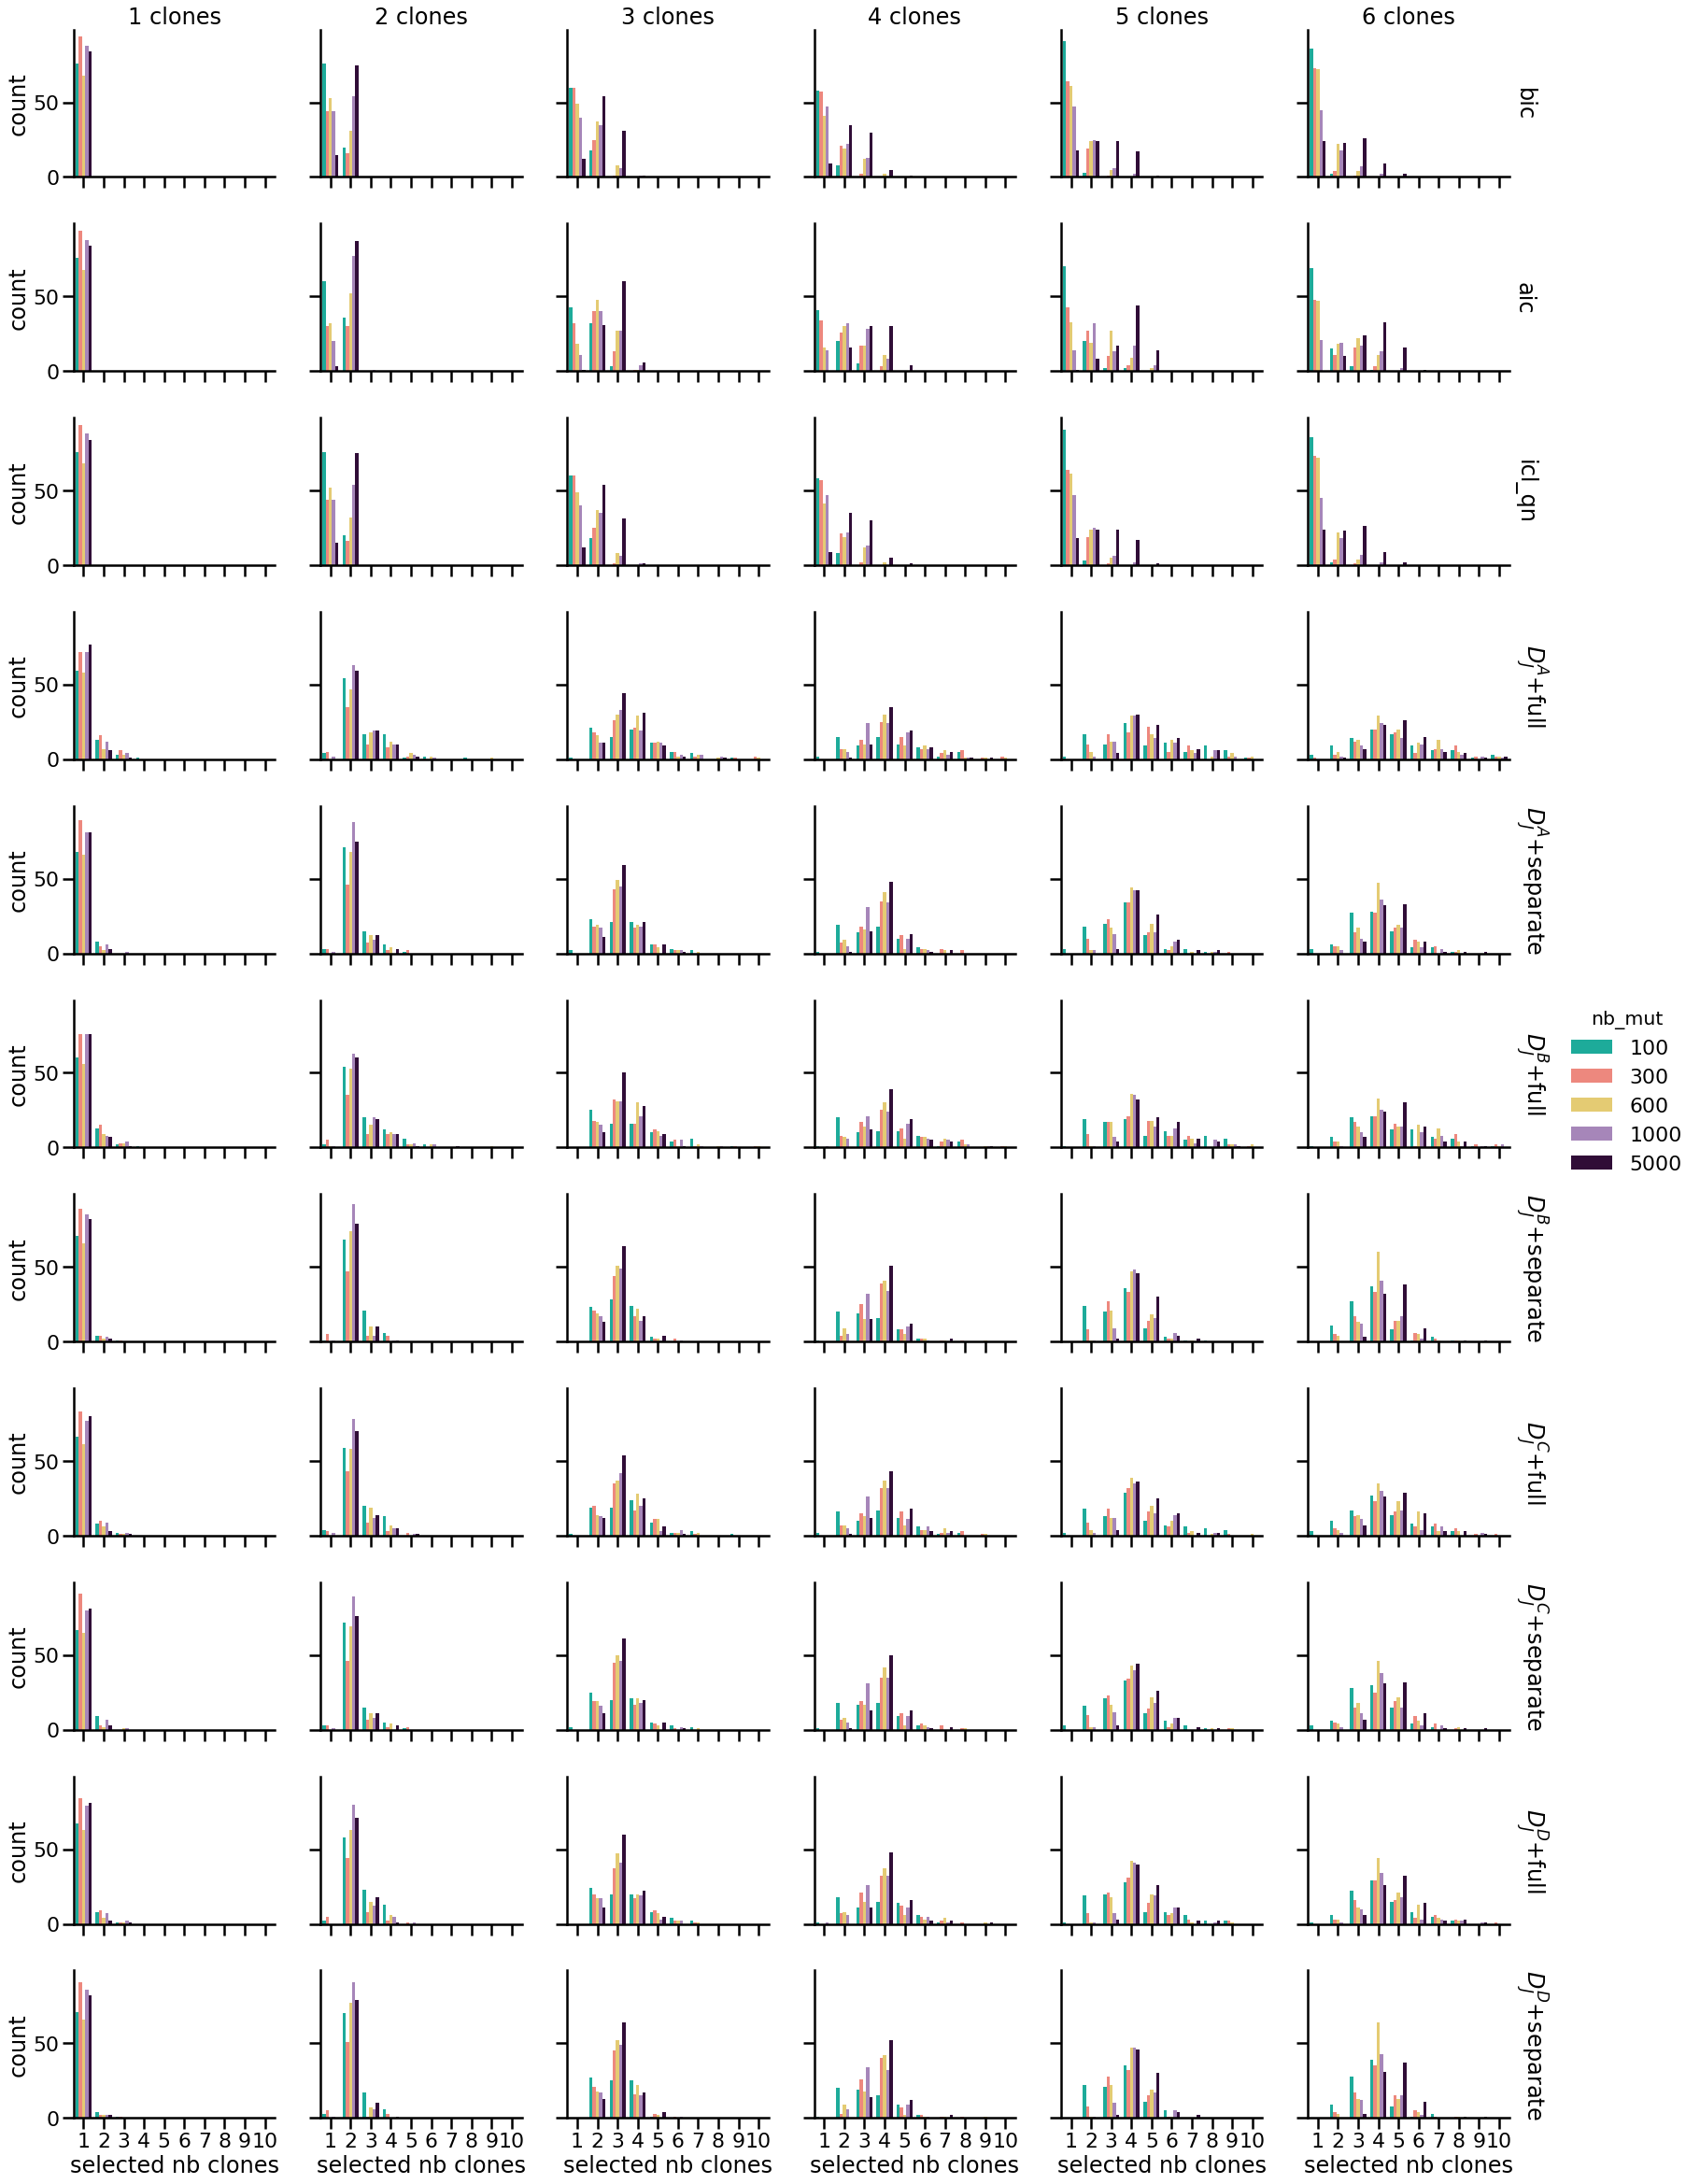

In [66]:
colors = ["turquoise", "salmon", "light mustard", "wisteria", "dark purple"]
pal = sns.xkcd_palette(colors)
sns.set_context("poster")

big_table=big_table.assign(method=big_table.method.str.replace('D_cn_nb_sig_lnN', '$D_J^A$').str.replace('D_nocn_nb_sig_lnN', '$D_J^B$').str.replace('D_cn_dof_lnN', '$D_J^C$').str.replace('D_nocn_dof_lnN', '$D_J^D$'))
g = sns.catplot(data=big_table[(big_table.split=='test')&((big_table.method.isin(['bic', 'aic', 'icl_qn'])|(big_table.method.str.contains('\+'))))], x="selected nb clones", col="nb_clones",
                row="method", hue='nb_mut', margin_titles=True, kind="count", palette=pal, height=3, aspect=1.3)
for row in g.axes:
    row[-1].texts = []
g = g.set_titles(col_template='{col_name} clones', row_template='{row_name}')
plt.savefig('20190801_paper_figures/repartition_nb_clones_criterion_test.pdf', bbox_inches='tight')


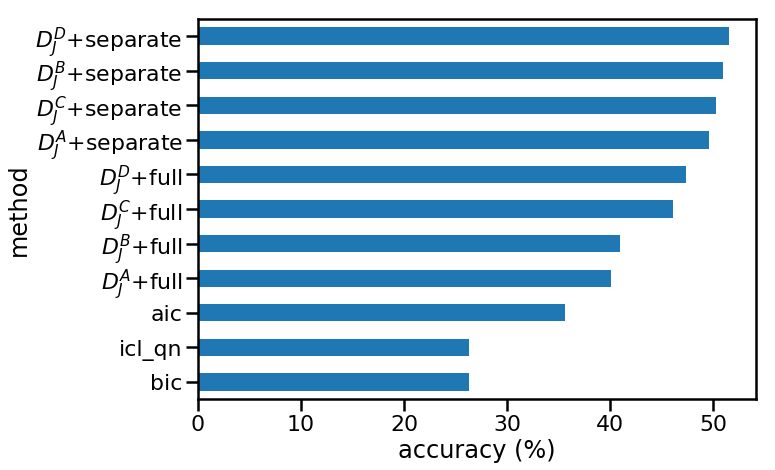

In [75]:
big_table = big_table.assign(ok=big_table.nb_clones==big_table['selected nb clones'])
fig, ax=plt.subplots(figsize=(10, 7))
test_df_acc=(big_table[(big_table.split=='test')&((big_table.method.isin(['bic', 'aic', 'icl_qn'])|(big_table.method.str.contains('\+'))))].groupby('method').ok.sum().sort_values()/len(big_simu[big_simu.split=='test']) * 100).to_frame()
test_df_acc.head()
#plt.bar(x=range(len(test_df_acc)), height=test_df_acc.ok)
test_df_acc.plot.barh(ax=ax)
ax.set_xlabel('accuracy (%)')
ax.get_legend().remove()
plt.savefig('20190801_paper_figures/model_selection_criterion_test_accuracy.pdf', bbox_inches='tight')


## Sanity check: variation of the accuracy with other parameters
### Accuracy and cancer type

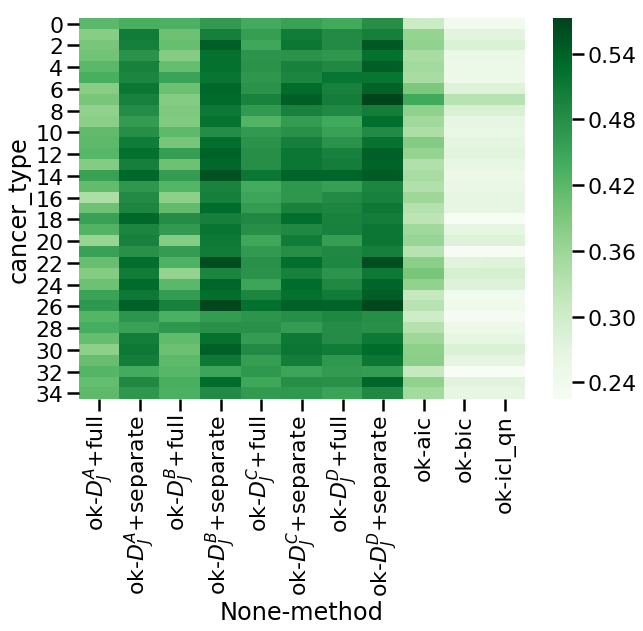

In [76]:
big_table_restrict = big_table[(big_table.method.isin(['bic', 'aic', 'icl_qn'])|(big_table.method.str.contains('\+')))]
plt.figure(figsize=(10, 7))
#TODO replace by cancer types names
sns.heatmap(big_table_restrict.pivot_table(index='cancer_type', columns='method', values=['ok'], aggfunc=sum) / big_table_restrict.pivot_table(index='cancer_type', columns='method', values=['ok'], aggfunc='count'), cmap='Greens')


### Accuracy and number of clones

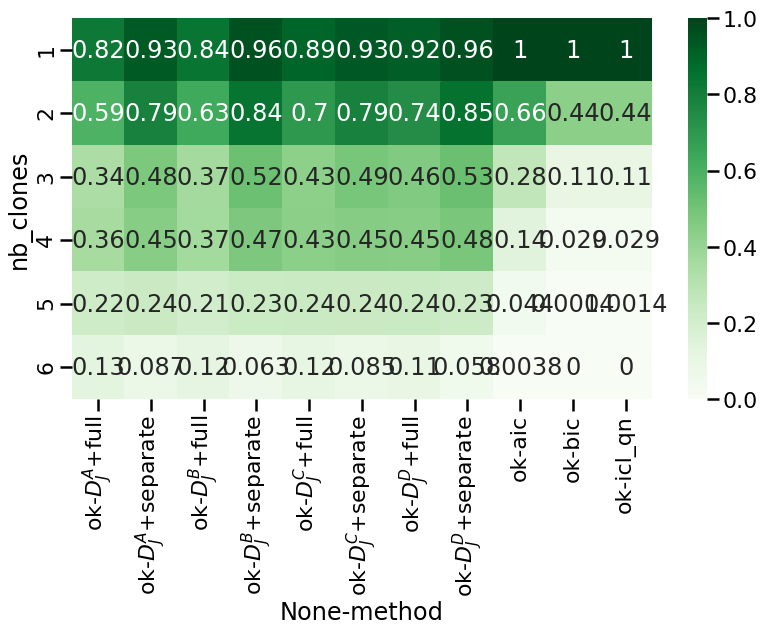

In [77]:
plt.figure(figsize=(13, 7))
sns.heatmap(big_table_restrict.pivot_table(index='nb_clones', columns='method', values=['ok'], aggfunc=sum) / big_table_restrict.pivot_table(index='nb_clones', columns='method', values=['ok'], aggfunc='count'), cmap='Greens', annot=True)

### Accuracy and copy number abundance

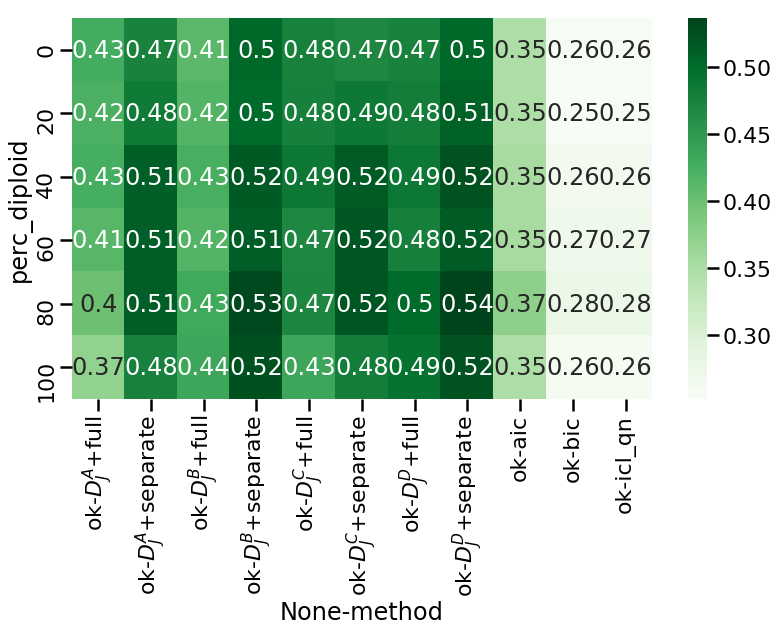

In [78]:
plt.figure(figsize=(13, 7))
sns.heatmap(big_table_restrict.pivot_table(index='perc_diploid', columns='method', values=['ok'], aggfunc=sum) / big_table_restrict.pivot_table(index='perc_diploid', columns='method', values=['ok'], aggfunc='count'), cmap='Greens', annot=True)


### Accuracy and minimal signature cosine distance between 2 clones

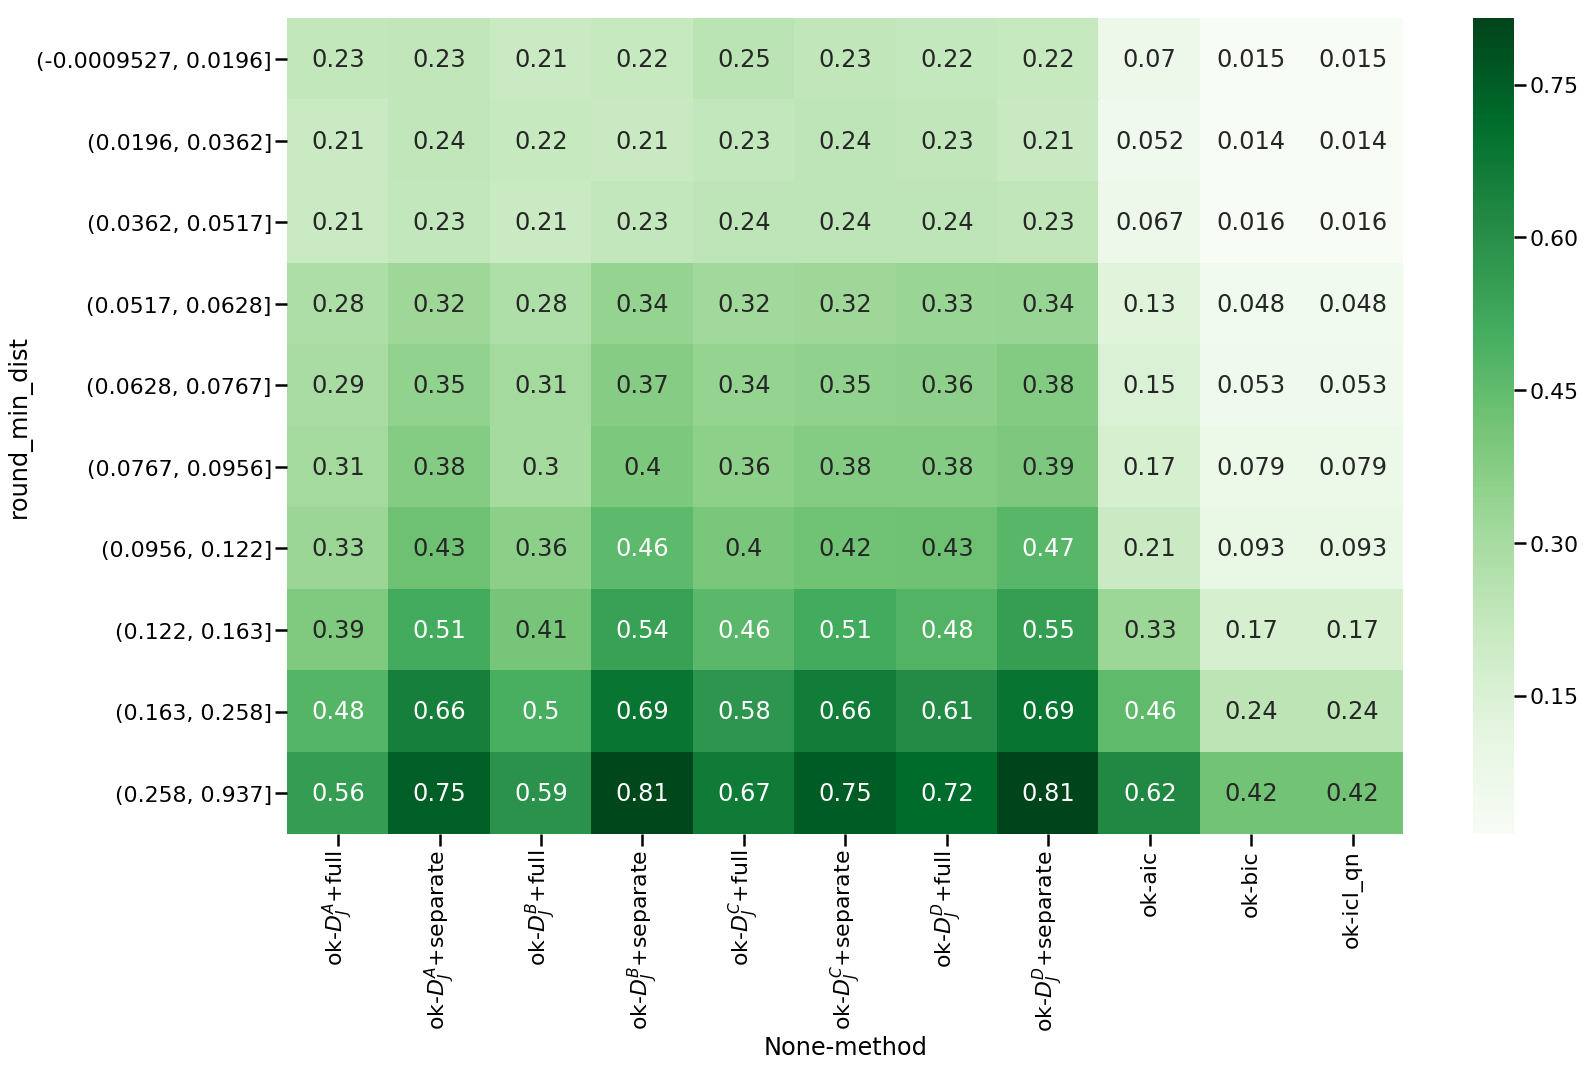

In [79]:
#big_table = big_table.assign(round_min_dist=np.round(big_table.min_dist, 2))
#big_table.loc[big_table.round_min_dist>0.5, 'round_min_dist'] = 0.5
val, bins = pd.qcut(big_table_restrict.min_dist, 10, retbins=True, precision=3, duplicates='drop')
big_table_restrict = big_table_restrict.assign(round_min_dist=val)
fig = plt.figure(figsize=(25,15))
sns.heatmap(big_table_restrict.pivot_table(index='round_min_dist', columns='method', values=['ok'], aggfunc=sum) / big_table_restrict.pivot_table(index='round_min_dist', columns='method', values=['ok'], aggfunc='count'), cmap='Greens', annot=True)
#https://stackoverflow.com/questions/43290853/how-to-create-heat-map-from-irregular-xyz-data-in-pyplot


### Accuracy and number of observed mutations

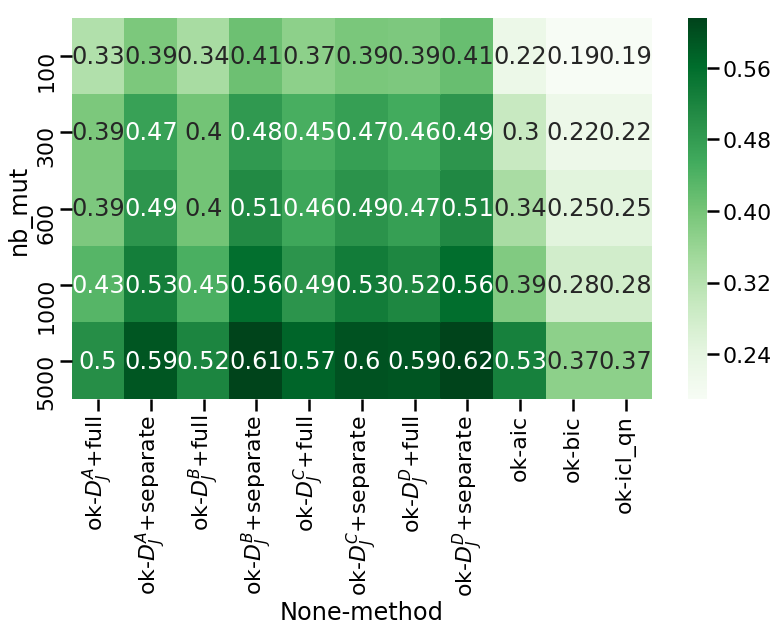

In [80]:
plt.figure(figsize=(13, 7))
sns.heatmap(big_table_restrict.pivot_table(index='nb_mut', columns='method', values=['ok'], aggfunc=sum) / big_table_restrict.pivot_table(index='nb_mut', columns='method', values=['ok'], aggfunc='count'), cmap='Greens', annot=True)
